In [1]:
import torch
from torch.utils.data import Dataset
import cv2
import os
import numpy as np
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub
class BUSIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {'normal': 0, 'benign': 1, 'malignant': 2}
        self.image_mask_label = []

        print(f"Scanning dataset at: {root_dir}")
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir): continue
            label = self.label_map.get(class_name.lower())
            if label is None: continue

            images = glob.glob(os.path.join(class_dir, '*.png'))
            for img_path in images:
                if '_mask' in img_path: continue
                mask_path = img_path.replace('.png', '_mask.png')
                if not os.path.exists(mask_path):
                    mask_path = None
                self.image_mask_label.append((img_path, mask_path, label))

        print(f"Dataset initialized successfully with {len(self.image_mask_label)} samples!")

    def __len__(self):
        return len(self.image_mask_label)

    def __getitem__(self, idx):
        img_path, mask_path, label_int = self.image_mask_label[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if mask_path is not None:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            mask = np.zeros_like(image)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = (image.astype('float32') / 255.0 - 0.5) / 0.5

        mask = (mask > 127).astype('float32')

        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask, torch.tensor(label_int, dtype=torch.long)

path = kagglehub.dataset_download("sabahesaraki/breast-ultrasound-images-dataset")
print("KaggleHub Download Path:", path)
root_dir = path
if 'Dataset_BUSI_with_GT' in os.listdir(path):
    root_dir = os.path.join(path, 'Dataset_BUSI_with_GT')
print(f"Using root directory: {root_dir}")

import albumentations as A
from torch.utils.data import DataLoader, random_split

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

val_transform = A.Compose([
    A.Resize(256, 256),
])

train_dataset = BUSIDataset(root_dir, transform=train_transform)
val_dataset_full = BUSIDataset(root_dir, transform=val_transform)

dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

generator = torch.Generator().manual_seed(42)
train_subset, _ = random_split(train_dataset, [train_size, val_size], generator=generator)

generator = torch.Generator().manual_seed(42)
_, val_subset = random_split(val_dataset_full, [train_size, val_size], generator=generator)

BATCH_SIZE = 8
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)


print("\n--- DataLoaders with Corrected Augmentation are Ready! ---")
print(f"Number of training samples: {len(train_subset)}")
print(f"Number of validation samples: {len(val_subset)}")

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
KaggleHub Download Path: /kaggle/input/breast-ultrasound-images-dataset
Using root directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
Scanning dataset at: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT


/tmp/ipython-input-1166329982.py:85: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Dataset initialized successfully with 780 samples!
Scanning dataset at: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
Dataset initialized successfully with 780 samples!

--- DataLoaders with Corrected Augmentation are Ready! ---
Number of training samples: 624
Number of validation samples: 156


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, features=[64, 128, 256, 512]):
        super().__init__()

        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        prev_channels = in_channels

        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
        ))
        self.pools.append(nn.MaxPool2d(kernel_size=2))

        prev_channels = 64
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
        ))
        self.pools.append(nn.MaxPool2d(kernel_size=2))

        prev_channels = 128
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
        ))
        self.pools.append(nn.MaxPool2d(kernel_size=2))

        prev_channels = 256
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
        ))
        self.pools.append(nn.MaxPool2d(kernel_size=2))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()

        self.ups.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
                nn.Conv2d(512+512, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
        ))

        self.ups.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
                nn.Conv2d(256+256, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
        ))

        self.ups.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
                nn.Conv2d(128+128, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
        ))

        self.ups.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
            nn.Conv2d(64+64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ))

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 3)
        )
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skip_connections.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        classification_output = self.classifier(x)
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.ups)):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.up_convs[idx](x)
        segmentation_output = self.final_conv(x)
        return segmentation_output, classification_output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import numpy as np

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs, dim=1)[:, 1]
        targets = targets.float()
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNET().to(device)
class_weights_seg = torch.tensor([0.1, 0.9]).to(device)
bce_loss = nn.CrossEntropyLoss(weight=class_weights_seg)
dice_loss = DiceLoss()
classification_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print("\n--- Starting Segmentation Pre-training ---")

train_subset_for_pretrain = train_loader.dataset

full_dataset_for_pretrain = train_subset_for_pretrain.dataset
train_indices_for_pretrain = train_subset_for_pretrain.indices

pretrain_indices_filtered = [i for i in train_indices_for_pretrain if full_dataset_for_pretrain.image_mask_label[i][2] > 0]

pretrain_subset = Subset(full_dataset_for_pretrain, pretrain_indices_filtered)

pretrain_loader = DataLoader(pretrain_subset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Pre-training on {len(pretrain_subset)} samples with masks.")

pretrain_epochs = 15
for epoch in range(pretrain_epochs):
    model.train()
    running_pretrain_loss = 0.0
    for images, masks, _ in pretrain_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        segmentation_output, _ = model(images)
        masks_squeezed = masks.squeeze(1).long()
        seg_loss_bce = bce_loss(segmentation_output, masks_squeezed)
        seg_loss_dice = dice_loss(segmentation_output, masks_squeezed)
        total_loss = seg_loss_dice + 0.5 * seg_loss_bce
        total_loss.backward()
        optimizer.step()
        running_pretrain_loss += total_loss.item()

    avg_pretrain_loss = running_pretrain_loss / len(pretrain_loader)
    print(f"Pre-train Epoch [{epoch+1}/{pretrain_epochs}], Seg Loss: {avg_pretrain_loss:.4f}")

print("--- Pre-training Finished. Starting Main Multi-Task Training ---\n")

num_epochs = 150
best_val_loss = float('inf')
patience = 20
patience_counter = 0
best_model_path = 'best_unet_model_final.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks, labels in train_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        segmentation_output, classification_output = model(images)
        masks_squeezed = masks.squeeze(1).long()
        has_mask = (labels > 0)
        segmentation_loss = torch.tensor(0.0, device=device)
        if has_mask.any():
            seg_loss_bce = bce_loss(segmentation_output[has_mask], masks_squeezed[has_mask])
            seg_loss_dice = dice_loss(segmentation_output[has_mask], masks_squeezed[has_mask])
            segmentation_loss = seg_loss_dice + 0.5 * seg_loss_bce
        classification_loss = classification_criterion(classification_output, labels)
        total_loss = 0.7 * segmentation_loss + 0.3 * classification_loss
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            seg_out, class_out = model(images)
            masks_squeezed = masks.squeeze(1).long()
            has_mask_val = (labels > 0)
            val_segmentation_loss = torch.tensor(0.0, device=device)
            if has_mask_val.any():
                val_seg_loss_bce = bce_loss(seg_out[has_mask_val], masks_squeezed[has_mask_val])
                val_seg_loss_dice = dice_loss(seg_out[has_mask_val], masks_squeezed[has_mask_val])
                val_segmentation_loss = val_seg_loss_dice + 0.5 * val_seg_loss_bce
            val_classification_loss = classification_criterion(class_out, labels)
            total_val_loss = 0.7 * val_segmentation_loss + 0.3 * val_classification_loss
            val_running_loss += total_val_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)

    print(f"\n--- Epoch {epoch+1} Summary ---")
    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("Model saved! (New best validation loss)")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\nStopping early after {epoch + 1} epochs.")
            break

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Final model loaded from best performing epoch.")
else:
    torch.save(model.state_dict(), 'final_unet_model_no_early_stop.pth')

print("Training finished.")

Using device: cuda

--- Starting Segmentation Pre-training ---
Pre-training on 515 samples with masks.
Pre-train Epoch [1/15], Seg Loss: 1.0979
Pre-train Epoch [2/15], Seg Loss: 0.9330
Pre-train Epoch [3/15], Seg Loss: 0.8752
Pre-train Epoch [4/15], Seg Loss: 0.8454
Pre-train Epoch [5/15], Seg Loss: 0.7953
Pre-train Epoch [6/15], Seg Loss: 0.7761
Pre-train Epoch [7/15], Seg Loss: 0.7653
Pre-train Epoch [8/15], Seg Loss: 0.7230
Pre-train Epoch [9/15], Seg Loss: 0.6962
Pre-train Epoch [10/15], Seg Loss: 0.7044
Pre-train Epoch [11/15], Seg Loss: 0.6742
Pre-train Epoch [12/15], Seg Loss: 0.6822
Pre-train Epoch [13/15], Seg Loss: 0.6583
Pre-train Epoch [14/15], Seg Loss: 0.6613
Pre-train Epoch [15/15], Seg Loss: 0.6506
--- Pre-training Finished. Starting Main Multi-Task Training ---


--- Epoch 1 Summary ---
Train Loss: 0.7126 | Validation Loss: 0.7930

Model saved! (New best validation loss)

--- Epoch 2 Summary ---
Train Loss: 0.7001 | Validation Loss: 0.7652

Model saved! (New best valid


--- Displaying Example 1 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (339).png


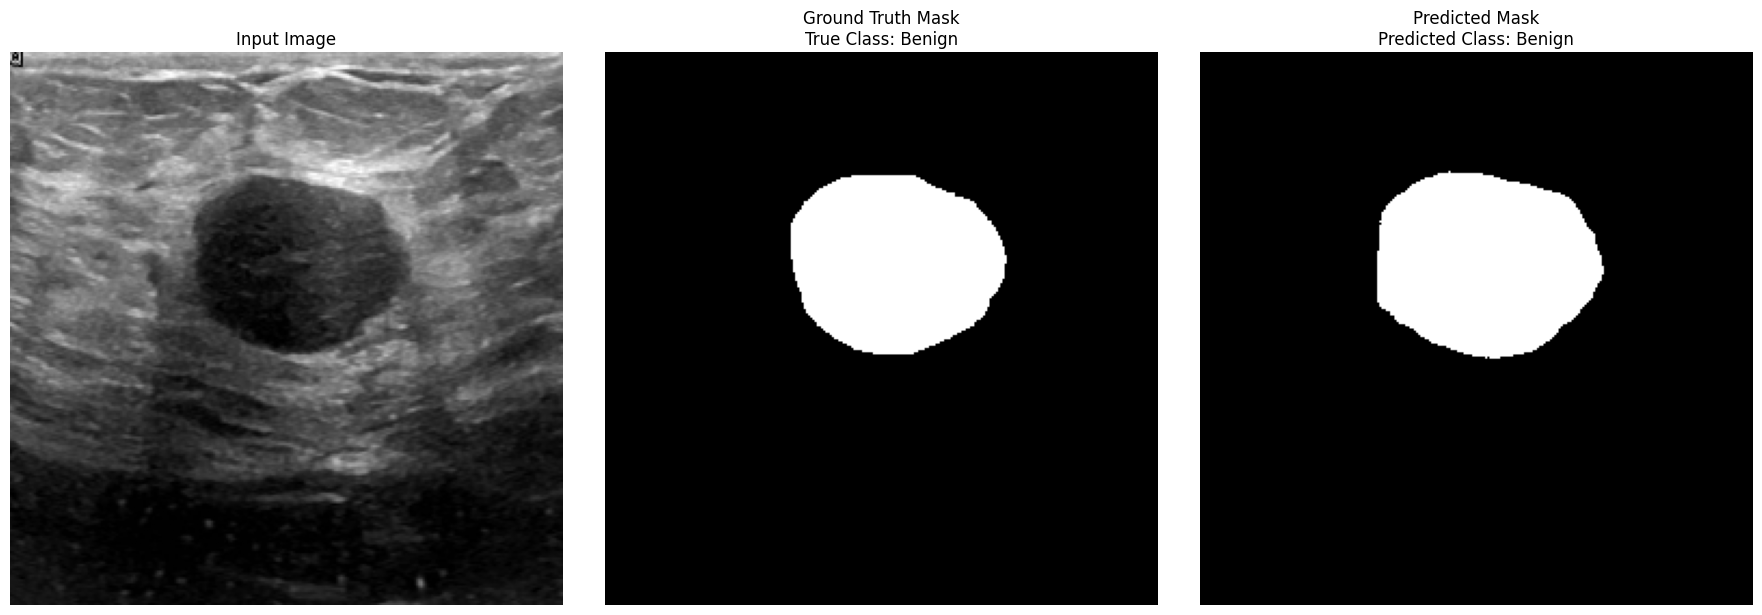

Summary for this image:
  - The TRUE class is: Benign
  - The MODEL PREDICTED the class as: Benign
  - Classification is CORRECT.

--- Displaying Example 2 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (110).png


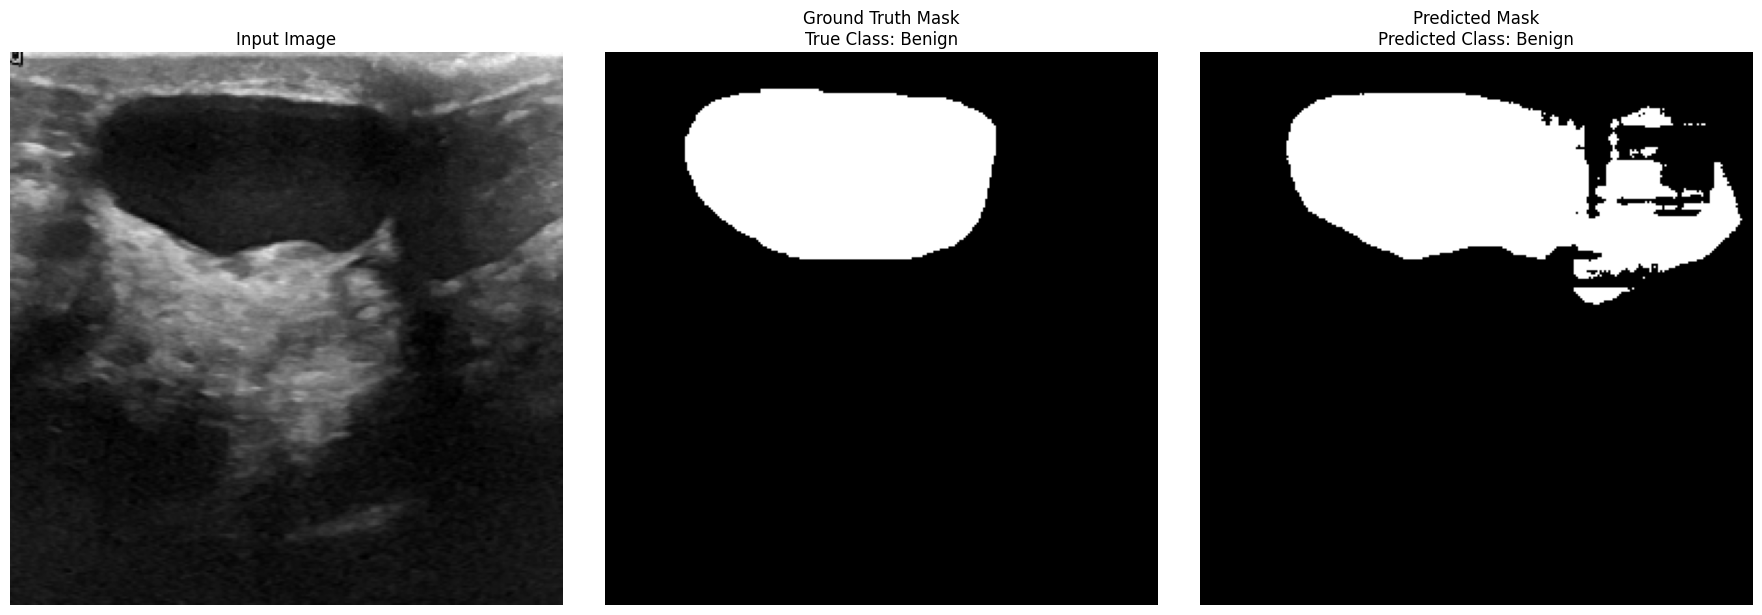

Summary for this image:
  - The TRUE class is: Benign
  - The MODEL PREDICTED the class as: Benign
  - Classification is CORRECT.

--- Displaying Example 3 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (21).png


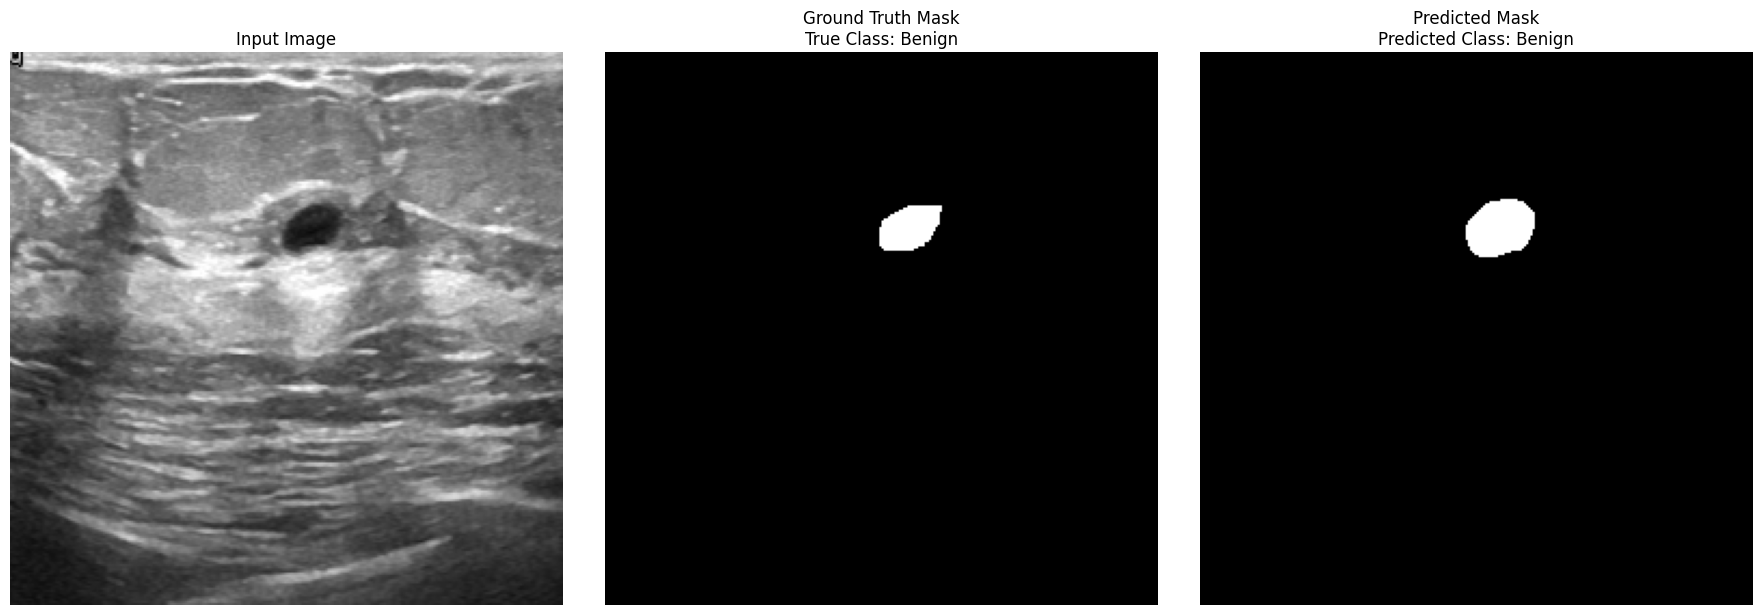

Summary for this image:
  - The TRUE class is: Benign
  - The MODEL PREDICTED the class as: Benign
  - Classification is CORRECT.

--- Displaying Example 4 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (302).png


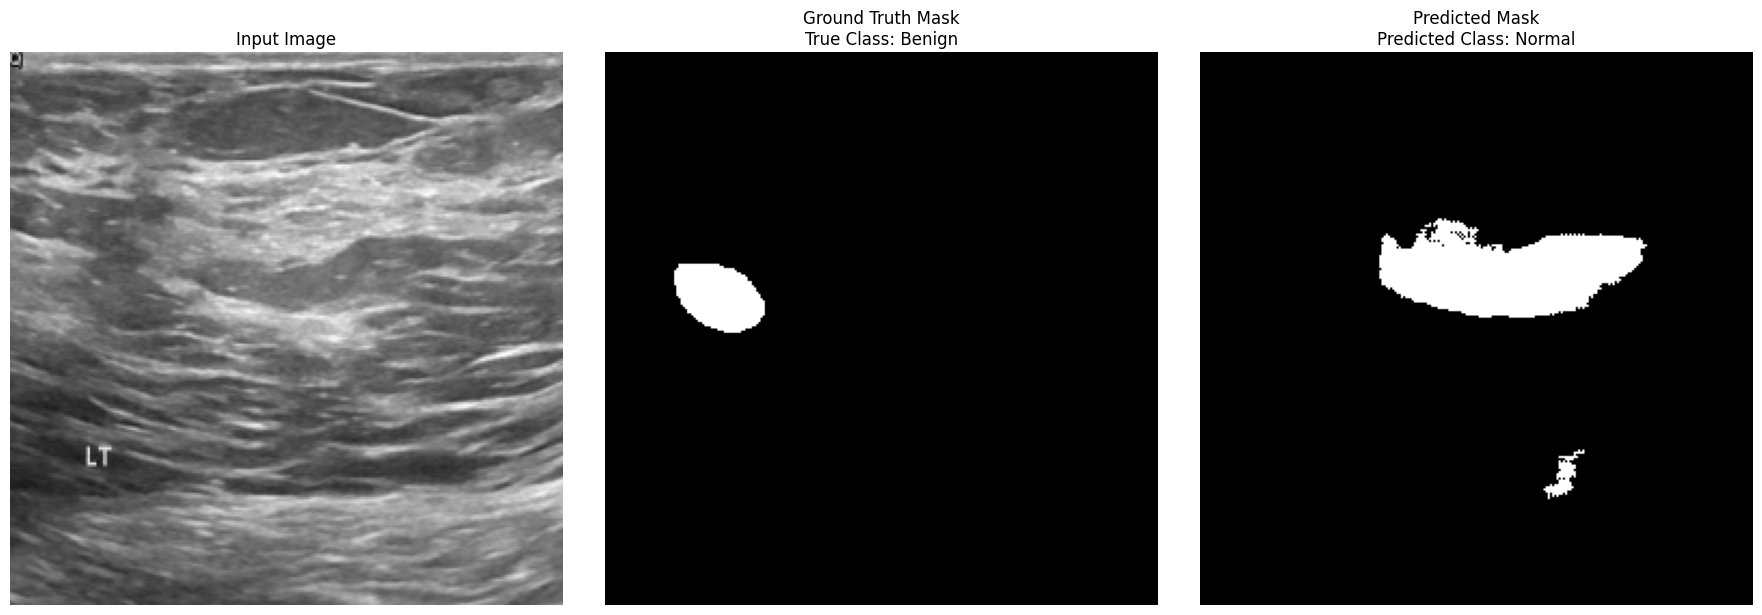

Summary for this image:
  - The TRUE class is: Benign
  - The MODEL PREDICTED the class as: Normal
  - Classification is INCORRECT.

--- Displaying Example 5 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (31).png


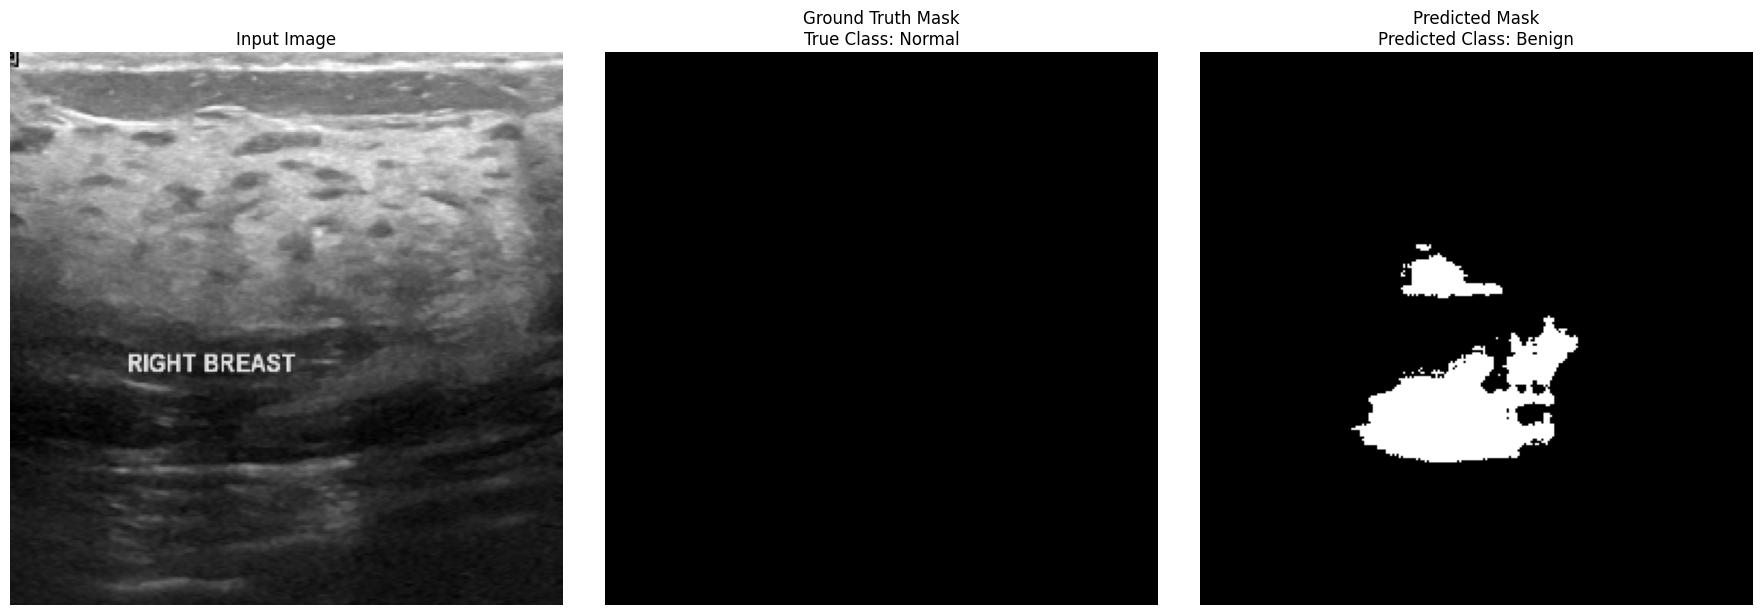

Summary for this image:
  - The TRUE class is: Normal
  - The MODEL PREDICTED the class as: Benign
  - Classification is INCORRECT.

--- Displaying Example 6 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (411).png


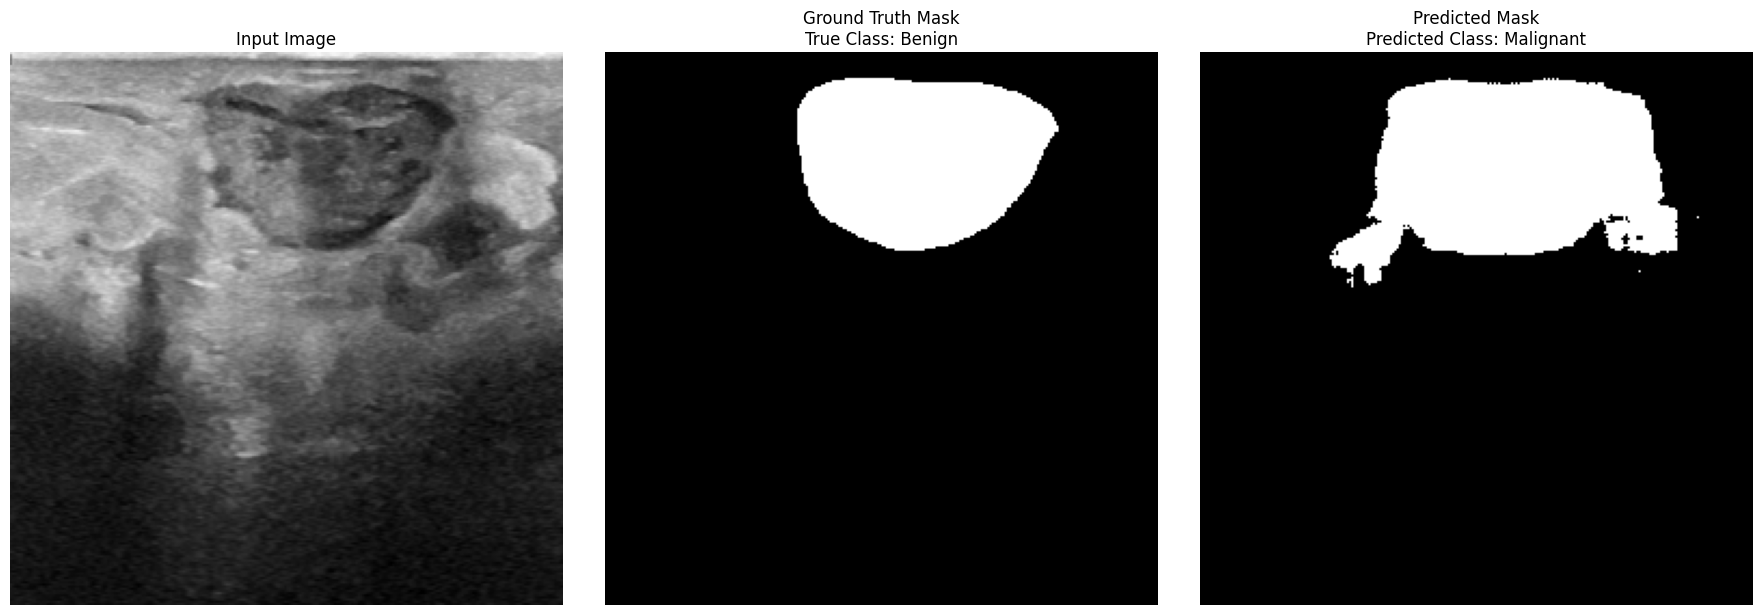

Summary for this image:
  - The TRUE class is: Benign
  - The MODEL PREDICTED the class as: Malignant
  - Classification is INCORRECT.

--- Displaying Example 7 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (99).png


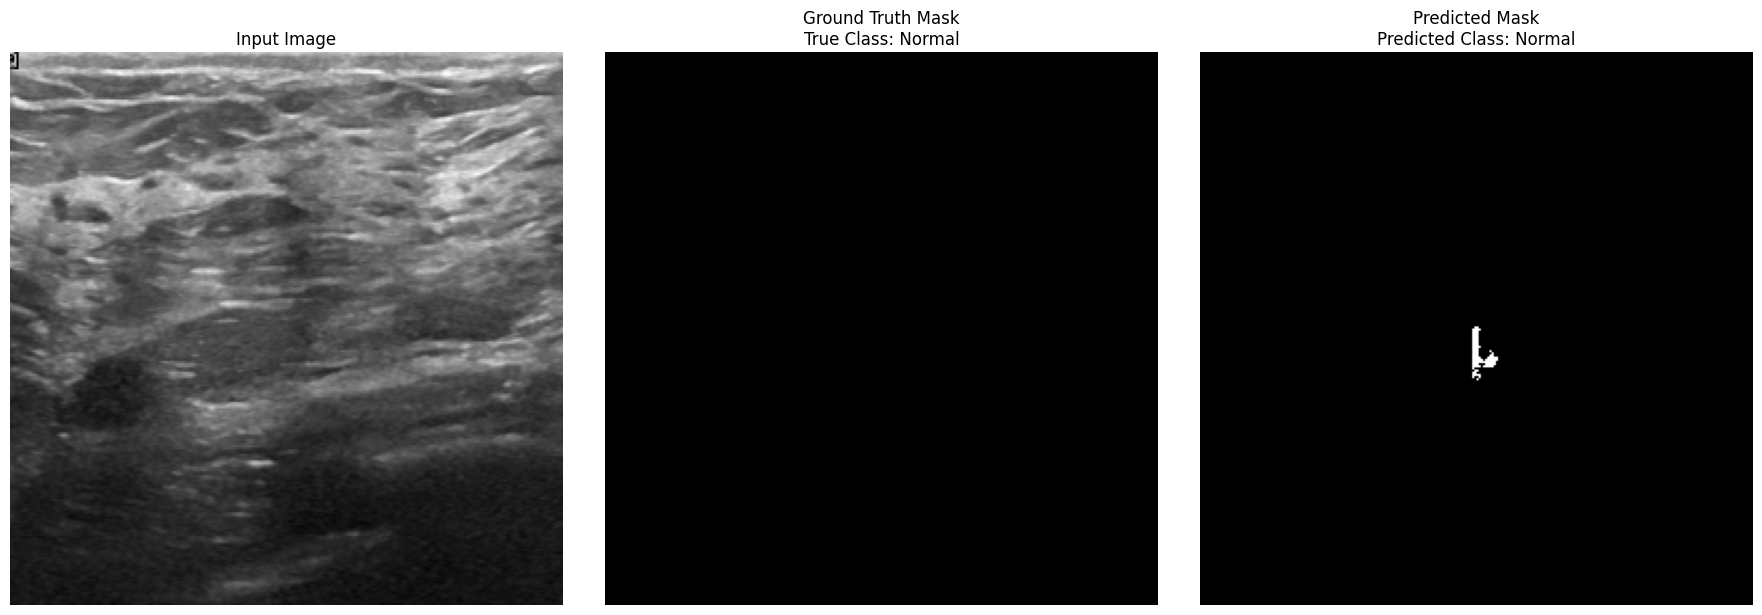

Summary for this image:
  - The TRUE class is: Normal
  - The MODEL PREDICTED the class as: Normal
  - Classification is CORRECT.

--- Displaying Example 8 of 8 ---
Image file path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (306).png


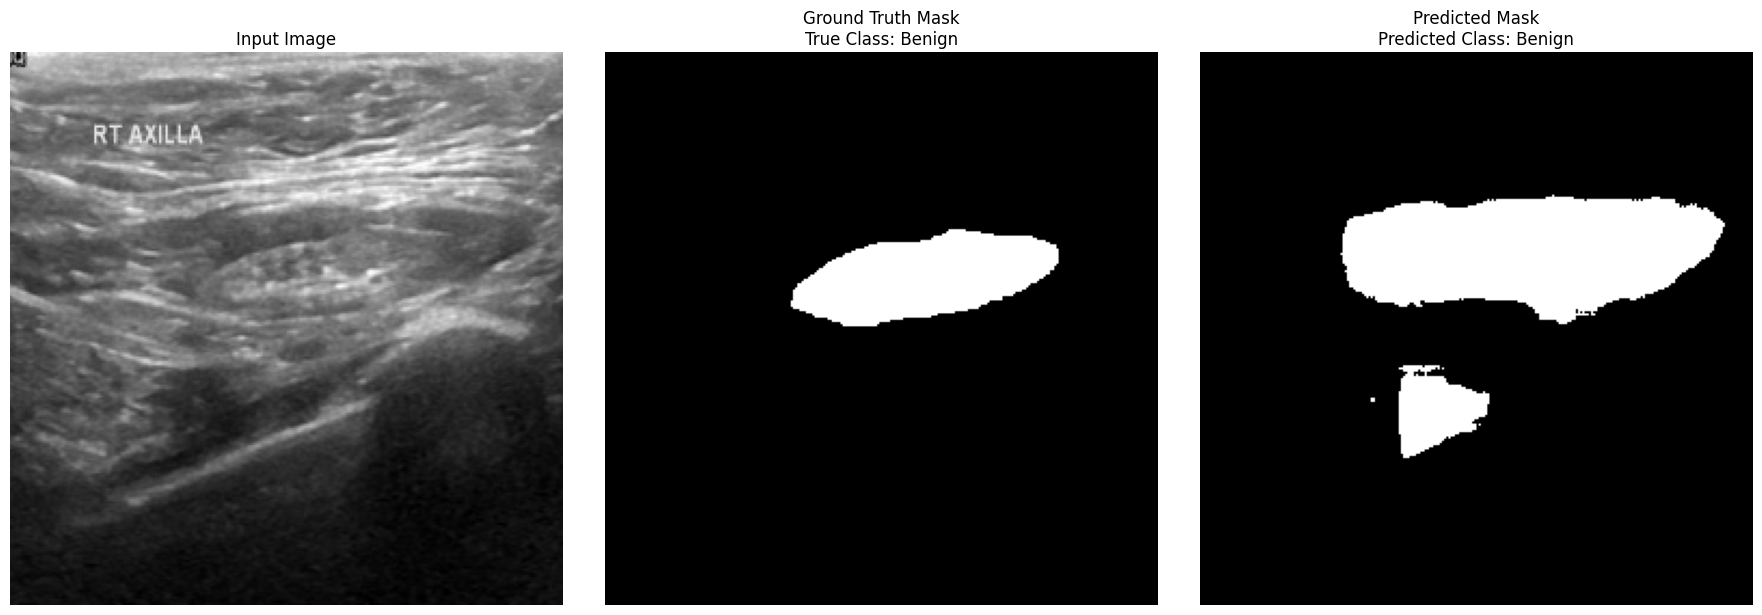

Summary for this image:
  - The TRUE class is: Benign
  - The MODEL PREDICTED the class as: Benign
  - Classification is CORRECT.


In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

class_names = ['Normal', 'Benign', 'Malignant']

val_images, val_masks, val_labels = next(iter(val_loader))
val_images = val_images.to(device)

model.eval()
with torch.no_grad():
    seg_output, class_output = model(val_images)
    probabilities = torch.softmax(seg_output, dim=1)
    val_pred_masks = torch.argmax(probabilities, dim=1)
    class_preds = torch.argmax(class_output, dim=1)

batch_size = val_images.size(0)
for i in range(batch_size):
    image_to_plot = val_images[i].cpu().numpy().squeeze()
    gt_mask_to_plot = val_masks[i].cpu().numpy().squeeze()
    pred_mask_to_plot = val_pred_masks[i].cpu().numpy().squeeze()

    original_idx = val_loader.dataset.indices[i]

    full_dataset_ref = val_loader.dataset.dataset
    img_path, _, _ = full_dataset_ref.image_mask_label[original_idx]

    true_label_idx = val_labels[i].item()
    pred_label_idx = class_preds[i].item()

    print(f"\n--- Displaying Example {i+1} of {batch_size} ---")
    print(f"Image file path: {img_path}")

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image_to_plot, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask_to_plot, cmap='gray')
    plt.title(f'Ground Truth Mask\nTrue Class: {class_names[true_label_idx]}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_to_plot, cmap='gray')
    plt.title(f'Predicted Mask\nPredicted Class: {class_names[pred_label_idx]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Summary for this image:")
    print(f"  - The TRUE class is: {class_names[true_label_idx]}")
    print(f"  - The MODEL PREDICTED the class as: {class_names[pred_label_idx]}")
    if true_label_idx == pred_label_idx:
        print("  - Classification is CORRECT.")
    else:
        print("  - Classification is INCORRECT.")

--- Segmentation Performance ---
Average Dice Score: 0.7183
Average IoU (Jaccard) Score: 0.5757

--- Classification Performance ---
Accuracy: 0.7949
Weighted F1-score: 0.7944
Weighted Precision: 0.8063
Weighted Recall: 0.7949
Matthews Correlation Coefficient (MCC): 0.6675


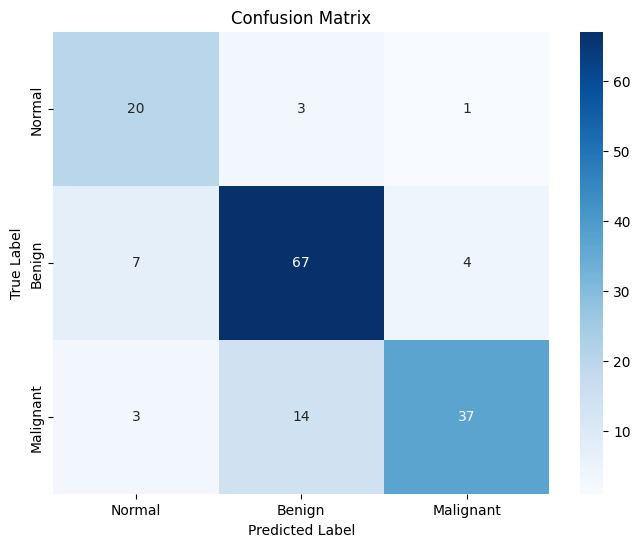

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_labels = []
all_class_preds = []

total_dice_score = 0.0
total_iou_score = 0.0
num_samples_with_mask = 0

class_names = ['Normal', 'Benign', 'Malignant']

with torch.no_grad():
    for images, masks, labels in val_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)

        seg_output, class_output = model(images)

        has_mask = (labels > 0)
        if has_mask.any():
            seg_output_filtered = seg_output[has_mask]
            masks_filtered = masks[has_mask].squeeze(1).long()

            seg_preds = F.softmax(seg_output_filtered, dim=1).argmax(dim=1)

            intersection = (seg_preds & masks_filtered).float().sum()
            union = (seg_preds | masks_filtered).float().sum()

            batch_dice = (2. * intersection) / (seg_preds.sum() + masks_filtered.sum() + 1e-6)
            batch_iou = intersection / (union + 1e-6)

            total_dice_score += batch_dice.item()
            total_iou_score += batch_iou.item()
            num_samples_with_mask += 1

        class_preds = torch.argmax(class_output, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_class_preds.extend(class_preds.cpu().numpy())


print("--- Segmentation Performance ---")
if num_samples_with_mask > 0:
    avg_dice = total_dice_score / num_samples_with_mask
    avg_iou = total_iou_score / num_samples_with_mask
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU (Jaccard) Score: {avg_iou:.4f}")
else:
    print("No samples with masks found in the validation set to evaluate segmentation.")

print("\n--- Classification Performance ---")

accuracy = accuracy_score(all_labels, all_class_preds)
mcc = matthews_corrcoef(all_labels, all_class_preds)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_class_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

cm = confusion_matrix(all_labels, all_class_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import gradio as gr
import cv2

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        prev_channels = in_channels
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64), nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64), nn.ReLU(inplace=True)))
        self.pools.append(nn.MaxPool2d(kernel_size=2))
        prev_channels = 64
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128), nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128), nn.ReLU(inplace=True)))
        self.pools.append(nn.MaxPool2d(kernel_size=2))
        prev_channels = 128
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256), nn.ReLU(inplace=True)))
        self.pools.append(nn.MaxPool2d(kernel_size=2))
        prev_channels = 256
        self.downs.append(nn.Sequential(
                nn.Conv2d(prev_channels, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512), nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512), nn.ReLU(inplace=True)))
        self.pools.append(nn.MaxPool2d(kernel_size=2))
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024), nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024), nn.ReLU(inplace=True))
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        self.ups.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
                nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512), nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512), nn.ReLU(inplace=True)))
        self.ups.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
                nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256), nn.ReLU(inplace=True)))
        self.ups.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128), nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128), nn.ReLU(inplace=True)))
        self.ups.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.up_convs.append(nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)))
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(1024, 256), nn.ReLU(inplace=True), nn.Linear(256, 3))
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    def forward(self, x):
        skip_connections = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skip_connections.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        classification_output = self.classifier(x)
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.ups)):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.up_convs[idx](x)
        segmentation_output = self.final_conv(x)
        return segmentation_output, classification_output

MODEL_PATH = "best_unet_model_final.pth"
CLASS_NAMES = ['Normal', 'Benign', 'Malignant']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gradio_model = UNET(in_channels=1, out_channels=2)
gradio_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
gradio_model.to(device)
gradio_model.eval()


def predict(input_image):
    image_np = np.array(input_image)
    if len(image_np.shape) > 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    image_resized = cv2.resize(image_np, (256, 256))
    image_normalized = (image_resized.astype(np.float32) / 255.0 - 0.5) / 0.5
    image_tensor = torch.from_numpy(image_normalized).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        seg_output, class_output = gradio_model(image_tensor)

    seg_probs = torch.softmax(seg_output, dim=1)
    seg_mask = torch.argmax(seg_probs, dim=1).squeeze().cpu().numpy().astype(np.uint8)
    seg_mask_colored = seg_mask * 255
    class_probs = torch.softmax(class_output, dim=1).squeeze().cpu().numpy()
    confidences = {name: float(prob) for name, prob in zip(CLASS_NAMES, class_probs)}

    return seg_mask_colored, confidences

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Ultrasound Image"),
    outputs=[
        gr.Image(type="numpy", label="Predicted Segmentation Mask"),
        gr.Label(label="Classification Result", num_top_classes=3)
    ],
    title="Breast Ultrasound Segmentation & Classification",
    description="This is a live demo of a U-Net model. Upload a breast ultrasound image to see the model predict the segmentation mask and classify the image as Normal, Benign, or Malignant.",
    allow_flagging="never"
)

iface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f619b62e0cba64e6b3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f619b62e0cba64e6b3.gradio.live
